Baseline after refresh 1:  [100.0, 1500.0]
Baseline after refresh 2:  [0, 2300.0]
Baseline after refresh 3:  [0, 2800.0]
Baseline after refresh 4:  [300.0, 4000.0]


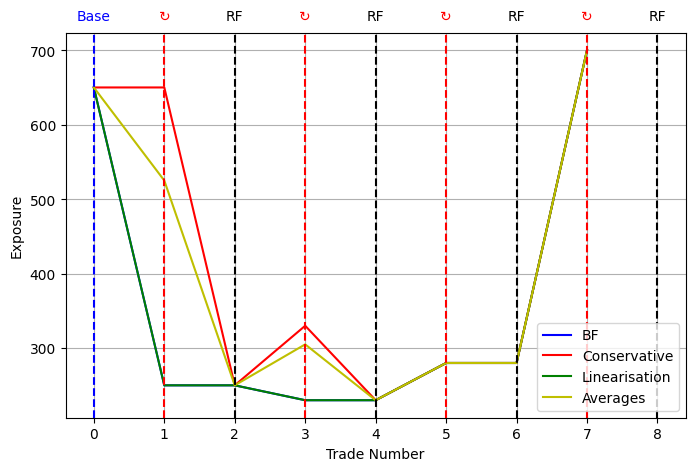

Impacts Matrix 
 [[-400.    0.    0.    0.]
 [-250.  800.    0.    0.]
 [-100.  500.    0.    0.]
 [ 300. 1200.    0.    0.]]


BF list  [650.0, 250.0, 250.0, 230.0, 230.0, 280.0, 280.0, 700.0]
Lin List [650.0, 250.0, 250.0, 230.0, 230.0, 280.0, 280.0, 700.0]


Conservative List [650.0, 650.0, 250.0, 330.0, 230.0, 280.0, 280.0, 700.0]
Average List [650.0, 525.0, 250.0, 305.0, 230.0, 280.0, 280.0, 700.0]


In [13]:

import numpy as np
import random
import matplotlib.pyplot as plt
import math
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual

def currentExposure(mtm):
    return max(0,mtm)


def addOn(notional, addOnFactor):
    return notional*addOnFactor


def totalExposure(mtm, notional, addOnFactor):
    currExp = currentExposure(mtm)
    currAddOn = addOn(notional, addOnFactor)

    return currExp + currAddOn

def psrBruteForce(position, impacts, addOnFactor, bf_list):
    
    total = 0
    totalMtm = position[0]
    totalNotional = position[1]
    
    total += totalExposure(totalMtm, totalNotional, addOnFactor)
    bf_list.append(total)
    
    for i in range(len(impacts)):

        totalMtm += impacts[i,0]
        totalNotional += impacts[i,1]
        total = totalExposure(totalMtm, totalNotional, addOnFactor)
        bf_list.append(total)
    
    return bf_list


def psrConservative(position, impacts, addOnFactor, cons_list):
    total = 0
    total += totalExposure(position[0], position[1], addOnFactor)
    cons_list.append(total)

    for i in range(len(impacts)):
        total += totalExposure(impacts[i,0], impacts[i,1], addOnFactor)
        cons_list.append(total)

    return cons_list

def psrLinearisation(position, impacts, addOnFactor, lin_list):
    total = 0
    position_exposure = totalExposure(position[0], position[1], addOnFactor)
    total += position_exposure
    lin_list.append(position_exposure)

    for i in range(len(impacts)):
        total += totalExposure(position[0]+impacts[i,0], position[1]+impacts[i,1], addOnFactor) - position_exposure
        
        # We implement the workaround as dicussed below
        lin_list.append(max(0, total))

        # lin_list.append(total)

    return lin_list

def psrAverages(position, impacts, addOnFactor, n, avg_list):
    total = 0
    position_exposure = totalExposure(position[0], position[1], addOnFactor)
    total += position_exposure
    avg_list.append(position_exposure)

    for i in range(len(impacts)):
        total += 1/n*(totalExposure(position[0]+n*impacts[i,0], position[1]+n*impacts[i,1], addOnFactor) - position_exposure)
        avg_list.append(total)

    return avg_list

def remove_outliers(data, threshold = 2):

    # The growth in exposure from the baseline can be exceptionally high for a small number of trades (since we are going from 0% difference to, for instance, a 20% differnce depending on the impacts we use).
    # This function removes the outliers that impact our analysis of the graph, by using standard mean and variance approaches

    n = len(data)
    mean = np.mean(data)
    std_dev = np.std(data)
    cleaned_data = data.copy()

    for i in range(len(data)):

        if -(mean+threshold*std_dev) < data[i] < (mean+threshold*std_dev):
            cleaned_data[i] = data[i]
        else:
            if i == 0:
                neighbors = [data[j] for j in range(max(0, i+5), min(len(data), i+3)) if j != i]
                cleaned_data[i] = np.median(neighbors)
            elif i == len(data) - 1:
                continue
            else:
                # Method: use median and neighbours
                neighbors = [data[j] for j in range(max(0, i-2), min(len(data), i+3)) if j != i]
                cleaned_data[i] = np.median(neighbors)
    return cleaned_data
    

def get_position_impacts(n):
    
    baseline_position = [400, 2000]
    mtm_notional_matrix = np.zeros((n,2))

    
    for i in range(n):

        mtm_notional_matrix[i,0] = random.randint(-200,200)
        mtm_notional_matrix[i,1] = random.randint(0,250)

    return [baseline_position, mtm_notional_matrix]

position_impacts_state = {"n": 0, "data": None}

def update_position_impacts(n):
    global position_impacts_state
    if position_impacts_state["n"] != n:
        position_impacts_state["n"] = n
        position_impacts_state["data"] = get_position_impacts_test(n)


def get_position_impacts_test(n=4):

    #baseline_position = [400, 2000]
    #mtm_notional_matrix = np.zeros((n,4))

    #mtm_notional_matrix[0,0] = 300
    #mtm_notional_matrix[1,0] = -400
    #mtm_notional_matrix[2,0] = 400
    #mtm_notional_matrix[3,0] = -400

    #mtm_notional_matrix[0,1] = 1000
    #mtm_notional_matrix[1,1] = 1000
    #mtm_notional_matrix[2,1] = 1000
    #mtm_notional_matrix[3,1] = 0

    baseline_position = [500, 1500]
    mtm_notional_matrix = np.zeros((n,4))

    mtm_notional_matrix[1,0] = -250
    mtm_notional_matrix[3,0] = 300
    mtm_notional_matrix[2,0] = -100
    mtm_notional_matrix[0,0] = -400

    mtm_notional_matrix[1,1] = 800
    mtm_notional_matrix[3,1] = 1200
    mtm_notional_matrix[2,1] = 500
    mtm_notional_matrix[0,1] = 0


    return [baseline_position, mtm_notional_matrix]


def exposure_simulation(n,m, addOn):
    
    update_position_impacts(n)
    baseline_position, mtm_notional_matrix = position_impacts_state["data"]
    
    addOnVal = addOn

    bf_list = []
    cons_list = []
    lin_list = []
    avg_list = []


    for i in range(int(n/m)):

        [bf_list, cons_list, lin_list, avg_list] = [psrBruteForce(baseline_position, mtm_notional_matrix[m*i:m*(i+1),:], addOnVal, bf_list),
                                                    psrConservative(baseline_position, mtm_notional_matrix[m*i:m*(i+1),:], addOnVal, cons_list),
                                                    psrLinearisation(baseline_position, mtm_notional_matrix[m*i:m*(i+1),:], addOnVal, lin_list),
                                                    psrAverages(baseline_position, mtm_notional_matrix[m*i:m*(i+1),:], addOnVal, n, avg_list)]
        
        mtmRefresh = baseline_position[0]+np.sum(mtm_notional_matrix[m*i:m*(i+1),0])
        notionalRefresh = baseline_position[1] + np.sum(mtm_notional_matrix[m*i:m*(i+1),1])
        
        # We introduce the workaround as discussed below
        baseline_position = [max(0, mtmRefresh), notionalRefresh]

        # baseline_position = [mtmRefresh, notionalRefresh]
        print("Baseline after refresh " + str(i+1) + ": ", baseline_position)

    x = np.linspace(0, n+int(n/m)-1, n+int(n/m))



    plt.figure(figsize=(8,5))
    plt.grid(True)
    plt.plot(x, bf_list, 'b', label = "BF")
    plt.plot(x, cons_list, 'r', label = "Conservative")
    plt.plot(x, lin_list, 'g', label = "Linearisation")
    plt.plot(x, avg_list, 'y', label = "Averages")
    plt.xlabel("Trade Number")
    plt.ylabel("Exposure")


    for i in range(int(n/m)):

        vline_x = (i+1)*(m+1)
        ymin, ymax = plt.ylim()
        plt.axvline(vline_x, color='k', linestyle='--')
        vline_x2 = (i+1)*(m+1)-1
        ymin2, ymax2 = plt.ylim()
        plt.axvline(vline_x2, color='r', linestyle='--')
        plt.text(vline_x, ymax + (ymax - ymin)*0.025, 'RF', ha="center", va = "bottom", color="k")
        plt.text(vline_x2, ymax2 + (ymax2 - ymin2)*0.025, '↻', ha="center", va = "bottom", color="r")

    vline_start = 0
    ymin3, ymax3 = plt.ylim()
    plt.axvline(vline_start, color='b', linestyle='--')
    plt.text(vline_start, ymax3 + (ymax3 - ymin3)*0.025, 'Base', ha="center", va = "bottom", color="b")

    plt.legend()
    plt.show()

    print("Impacts Matrix \n", mtm_notional_matrix)
    
    print("\n")
    
    print("BF list ", bf_list)
    print("Lin List", lin_list)
    
    print("\n")
    
    print("Conservative List", cons_list)
    print("Average List", avg_list)




#interact(exposure_simulation,
#         n=widgets.IntSlider(min=1, max=100, step=1, value=10, description="# of Trades"),
#         m=widgets.IntSlider(min=1, max=100, step=1, value =5, description="Refresh Cycle"),
#         addOn = widgets.FloatSlider(min=0,max=1,step=0.01,value=0.50,description="AddOnFactor"),
#         )

exposure_simulation(4,1,0.1)

# There are two special cases where the Linear approach goes below the Brute Force approach.

# When the refresh takes us to a new basleine position where the mtm is negative. This in turn affects the linearisation. To see this, note 
# how the linear approach calcuates the differnce between a new position and the baseline refresh individaully. If the baseline is negative
# what happens is it will not grow as fast as the brute force does, and so brute force will go above. 

# When the current position is close to zero and an incoming contract causes the new position to be negatvie. The brute force method will go to zero 
# however the linear method will end up going further below and become negative.

# To get around these two problems, we have two implement two things in the code.

# 1 .The first (and easy) workaround is to stop the refresh from setting a negative baseline. One easy solution is to just set the new MTM to 0 (chat to Rory about this)


# 2 .The second workaround is to stop the linear graph from going below when the exposure is close to zero. How can one do this?

# Let's say we are calculating the linear exposure: p = 1 , x1 = x2 = -1
# we get for BF : rho( p + x1 + x2 ) = 0 

# but for Linear: rho(p) + ( rho(p+x1) - rho(p) ) + ( rho(p+x2) - rho(p) ) = -1 . 

# What we can do here is keep a tally of the total exposure of the linear approach. So if the next difference delta_i is going
# to cause the sum to go to below zero, then we can just make the linear exposure return max(0, total_sum). This should counteract the error in question.

# INTERESTING SITUATION
# Now let the notional be arbitrarily large and the mtm to be sort of close to zero. If we have an addon factor that is quite large (say 0.5) what happens is the Linearisation 
# approach will sink to zero (due to the way in which it is defined), and brute force will stay positive since the Notional* AddOnFactor always adds on each time (though it should sink to zero)
# Note that on the graph if we sink this down to zero, the BF and Linear will merge!

# SOLUTION: The simple resolution is avoidance: don't run a simulation where there is a high possibility the exposure will tend to zero at some point (set high MTM's with lower notionals). 
# Or, if there is a piece of code that does a dynamic refresh when the exposure is closing in on zero (and the next impact would ultimately 
# send the exposure to a negative number), or make the graphs behave differently until it finally moves away from that point
# SOLUTION: Another solution would be more frequent refreshes. Therefore, if there is a risk of the linear going under, the baseline refreshes so it doesn't happen for too long.